# Obtenção de rating do contribuinte

Com o objetivo de direcionar o modelo que ditá quais dívidas são melhores de recuperar, será realizado um rating que envolva apenas as variáveis do contribuinte.

In [36]:
import os
import pandas as pd
import zipfile
from datetime import date
import dotenv
import boto3
from io import BytesIO
import locale
locale.setlocale(locale.LC_ALL, 'pt_BR.utf8')

import warnings
warnings.filterwarnings("ignore")

rootPath = os.getcwd()
dataPath = os.path.join(rootPath, 'data')
modelsPath = os.path.join(rootPath, 'models')
env = os.path.join(rootPath, '.env')
dotenv.load_dotenv(dotenv_path=env)

print("Iniciando carregamento dos dados")
zip_file = os.path.join(dataPath, 'base_treino.zip')
z = zipfile.ZipFile(zip_file)

def ler_bases_exportadas(nome_arquivo):
    z.extract(nome_arquivo)
    df = pd.read_csv(nome_arquivo, sep=',')
    os.remove(nome_arquivo)
    return df

def up_s3_files(dataframe, bucket_name, folder_name, file_name):
    csv_buffer = BytesIO()
    dataframe.to_csv(csv_buffer, sep=';', index=False)
    file_key_aws = folder_name + file_name
    s3_resource.Object(bucket_name, file_key_aws).put(Body=csv_buffer.getvalue())

base_conjunta = ler_bases_exportadas('imovel_mercantil.csv')
base_notas_fiscais = ler_bases_exportadas('emissao_notas.csv')




Iniciando carregamento dos dados


In [37]:
print("Inicia transformação das variáveis sobre a dívida")

# Gera as variáveis de tempo
base_conjunta['data_divida'] = pd.to_datetime(base_conjunta['inscricao_divida'], infer_datetime_format = True)

base_conjunta['ano_inscricao_da'] = base_conjunta['data_divida'].dt.year
base_conjunta['mes_inscricao_da'] = base_conjunta['data_divida'].dt.month

base_conjunta.drop_duplicates(subset='cda', inplace=True) #Garantia que não houve duplicatas de linhas



Inicia transformação das variáveis sobre a dívida


In [38]:
base_conjunta.columns

Index(['cda', 'tipo_divida', 'id_contribuinte', 'atividade_principal',
       'situacao', 'tipo_tributo', 'vlr_pago', 'valor_tot', 'vlr_tributo',
       'vlr_taxa', 'competencia_divida', 'inscricao_divida',
       'arrecadacao_divida', 'ajuizamento_divida', 'edificacao',
       'cpf_cnpj_existe', 'protesto', 'ajuizamento', 'refis', 'deb_totais',
       'deb_pagos', 'idade_divida', 'quantidade_reparcelamento', 'da_aberto',
       'data_divida', 'ano_inscricao_da', 'mes_inscricao_da'],
      dtype='object')

In [39]:
# Seleciona dados sobre a divida
dados_divida = base_conjunta[[ 'cda', 'id_contribuinte', 'tipo_divida', 'valor_tot', 'vlr_pago', 
                              'protesto', 'ajuizamento', 'inscricao_divida', 'quantidade_reparcelamento', 
                              'idade_divida', 'ano_inscricao_da', 'mes_inscricao_da']]
dados_divida.rename(columns={'id_contribuinte': 'id_pessoa'}, inplace=True)
dados_divida.dropna(subset=['id_pessoa'], inplace=True)
dados_divida['id_pessoa'] = dados_divida['id_pessoa'].astype(str) # persistindo tipo de dados
dados_divida

,cda,id_pessoa,tipo_divida,valor_tot,vlr_pago,protesto,ajuizamento,inscricao_divida,quantidade_reparcelamento,idade_divida,ano_inscricao_da,mes_inscricao_da
0,00000123c3d4731c6b3a8e268c80aedf1,ac28642d7c82b33f,imovel,2048.73,0.0,0,0,2022-09-07,0,1.0,2022,9
1,00000123c3d4731c6b3a8e268c80aedf2,fc4b99b807fbed41,mercantil,2515.85,0.0,0,0,2022-12-30,0,1.0,2022,12
2,00000b44c5ba1e669ceed47545e621dd2,96e8e553de69d7a4,mercantil,1278.97,0.0,0,0,2002-09-07,0,21.0,2002,9
3,000014e359592e62d8a3e5cebc255ca6E,6dbe14da38a31dc1,mercantil,847.02,0.0,0,0,2023-06-15,0,0.0,2023,6
4,0000331f601a73e52b46f673bf0c61251,870c08c252b25ad1,imovel,344.12,0.0,0,0,2012-10-17,0,11.0,2012,10
...,...,...,...,...,...,...,...,...,...,...,...,...
2414893,ffffd8af5760cada9fcacff532cf50c41,d411f54ad97d1f39,imovel,1728.13,0.0,0,0,2019-06-28,0,4.0,2019,6
2414894,ffffdb721b90282718565e26094f06ee2,51d6043a4efa1ed1,mercantil,240.77,0.0,0,0,2017-10-22,0,6.0,2017,10
2414895,ffffdc78aa7a90e26b3a8e268c80aedf1,9b512f210b460120,imovel,9390.43,0.0,0,1,1998-11-26,0,25.0,1998,11
2414896,fffff192f894983c9ceed47545e621dd1,dd5538d2d38803a7,imovel,16594.80,0.0,0,1,2008-10-05,0,15.0,2008,10


---

In [23]:
df = dados_divida.query('idade_divida <= 5')
df = df.query('ano_inscricao_da <= 2023')

In [24]:
resultados = df.groupby(['ano_inscricao_da', 'mes_inscricao_da'])['cda'].count().reset_index()
meses_maximos = resultados.loc[resultados.groupby('ano_inscricao_da')['cda'].idxmax()]
meses_maximos

,ano_inscricao_da,mes_inscricao_da,cda
6,2018,7,158168
17,2019,6,82228
35,2020,12,143914
46,2021,11,87288
56,2022,9,109767
60,2023,1,4347


In [25]:
meses_maximos_somados = meses_maximos.groupby('mes_inscricao_da')['cda'].sum().reset_index()
meses_maximos_somados = meses_maximos_somados.sort_values(by='cda', ascending=False)
meses_maximos_somados

,mes_inscricao_da,cda
2,7,158168
5,12,143914
3,9,109767
4,11,87288
1,6,82228
0,1,4347


In [26]:
contagem_meses_distintos = meses_maximos.groupby('mes_inscricao_da')['mes_inscricao_da'].count().to_frame()
contagem_meses_distintos

,mes_inscricao_da
mes_inscricao_da,
1,1
6,1
7,1
9,1
11,1
12,1


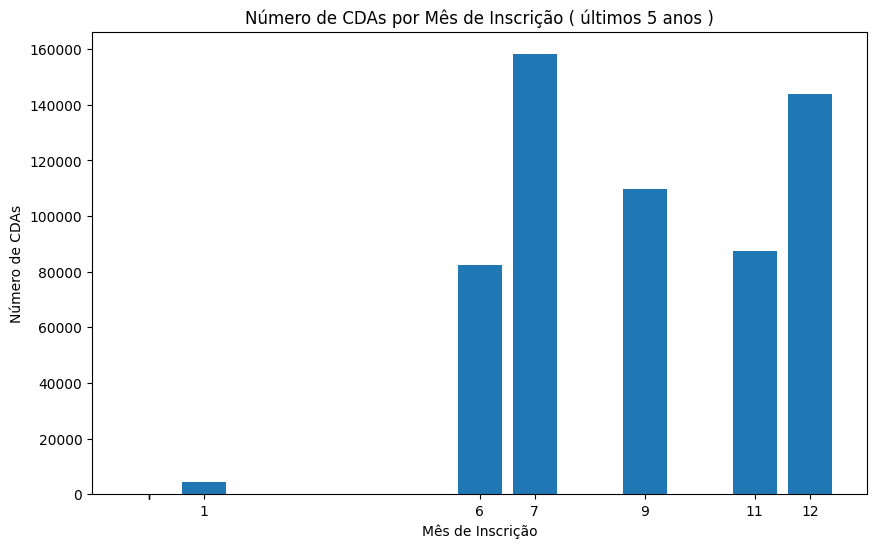

In [31]:
import matplotlib.pyplot as plt
import numpy as np

meses = meses_maximos_somados['mes_inscricao_da']
cdas = meses_maximos_somados['cda']

eixo_x_customizado = np.arange(1, 13)
eixo_x_customizado = [mes if mes in meses.values else 0 for mes in eixo_x_customizado]

contagem_cdas_por_mes = [cdas[meses == mes].values[0] if mes in meses.values else 0 for mes in eixo_x_customizado]

plt.figure(figsize=(10, 6))
plt.bar(eixo_x_customizado, contagem_cdas_por_mes)

plt.xlabel('Mês de Inscrição')
plt.ylabel('Número de CDAs')
plt.title('Número de CDAs por Mês de Inscrição ( últimos 5 anos )')

plt.xticks(rotation=0)

eixo_x_labels = [str(mes) if mes != 0 else '' for mes in eixo_x_customizado]
plt.xticks(eixo_x_customizado, eixo_x_labels)

plt.show()


---

In [41]:
# Renomeia colunas para nome mais adequados e filtra dataframe
colunas_nome = {
    'valor_tot': 'valor_total_da'
}
df_divida_ativa = dados_divida.rename(columns=colunas_nome)


# Criando variável target Y que será predita
df_divida_ativa['percentual_pago_cda'] = df_divida_ativa['vlr_pago'] / df_divida_ativa['valor_total_da']


print("Inicia a conexão com S3 para inscrição dos dados")
# Cria conexão ao s3 e preenche a tabela com os dados
s3_resource = boto3.resource(
    service_name='s3',
    region_name='us-east-1',
    aws_access_key_id=os.getenv("AWS_ACESS_KEY"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACESS_KEY")
    )

def up_s3_files(dataframe, bucket_name, folder_name, file_name):
    csv_buffer = BytesIO()
    dataframe.to_csv(csv_buffer, sep=';', index=False)
    file_key_aws = folder_name + file_name
    s3_resource.Object(bucket_name, file_key_aws).put(Body=csv_buffer.getvalue())

up_s3_files(dataframe=df_divida_ativa, 
            bucket_name=os.getenv("S3_BUCKET_NAME"),
            folder_name=os.getenv("S3_FOLDER_NAME"), 
            file_name='feature_store_divida_prime_2.csv')

print("Dados atualizados e persistidos no bucket S3")
print("Processo finalizado")

Inicia a conexão com S3 para inscrição dos dados
Dados atualizados e persistidos no bucket S3
Processo finalizado
